# Multiple Peaks Simulations

Next, simulate power spectra with variable numbers of peaks, and test fitting on them. 

In [1]:
import pickle
from collections import Counter

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from fooof import FOOOFGroup, fit_fooof_group_3d
from fooof.sim import gen_group_power_spectra

In [2]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from settings import *
from utils import *
from plts import *

## Settings

In [3]:
# Set random seed
import random
random.seed(333)

In [4]:
# Set plotting style from seaborn
sns.set_style('white')

In [5]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = True

### Simulate Power Spectra

In [6]:
# Set the number of PSDs - this is per n_osc condition
n_psds = 1000

# Set the noise levels to use
n_oscs = [0, 1, 2, 3, 4]
nlv = 0.01
#nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & aperiodic parameters
peaks = []
for n_osc in n_oscs:
    peaks.append(gen_osc_def(n_osc))
aps = gen_ap_def()

In [7]:
# Get data sizes
n_n_oscs = len(n_oscs)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [8]:
# Generate or load power spectra
data_name = 'multi_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    freqs = np.empty(shape=n_freqs)
    psds = np.empty(shape=[n_n_oscs, n_psds, n_freqs])
    mp_sim_params = [None] * n_n_oscs

    # Generate simulated power spectra
    for n_ind, n_osc, peaks in zip(range(n_n_oscs), n_oscs, peaks):
        freqs, psds[n_ind, :, :], mp_sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv, F_RES)
        
    # Save out generated simulations & parameter definitions
    np.savez(DATA_PATH + data_name + '.npz', freqs, psds)
    with open(DATA_PATH + data_name + '.p', 'wb') as f_obj:
        pickle.dump(mp_sim_params, f_obj)
        
else:
    
    # Load previously generated simulations & parameter definitions
    temp = np.load(data_path + data_name + '.npz')
    freqs, psds = temp['arr_0'], temp['arr_1']
    with open(data_path + data_name + '.p', 'rb') as f_obj:
        mp_sim_params = pickle.load(f_obj)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [9]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(mp_sim_params)

In [10]:
# Initialize FOOOFGroup to test with
mp_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=0.1)

# Check settings for FOOOF used to fit multiple peak simulations
mp_fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [11]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
mp_fgs = fit_fooof_group_3d(mp_fg, freqs, psds)

Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.
Running FOOOFGroup across 1000 power spectra.


In [12]:
# Extract data of interest from FOOOF fits
_, ap_fits, err_fits, r2_fits, n_fit_oscs = get_fit_data(mp_fgs)

# Calculate error
ap_errors = np.abs(ap_truths - ap_fits)

### Create Plots

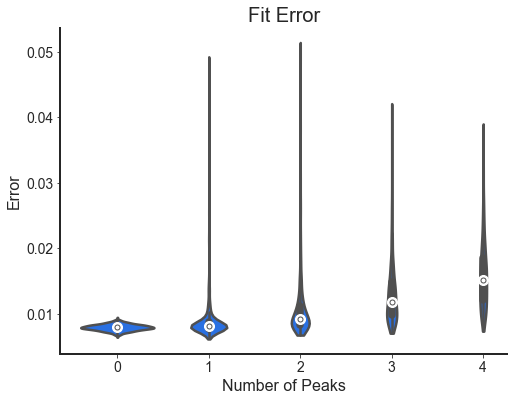

In [13]:
# Multi-peak fitting: plot error levels across number of peaks
plot_errors_violin(err_fits, 'Fit Error',
                   x_axis='n_oscs', plt_log=False,
                   save_fig=SAVE_FIG, save_name='MPeak-Err')

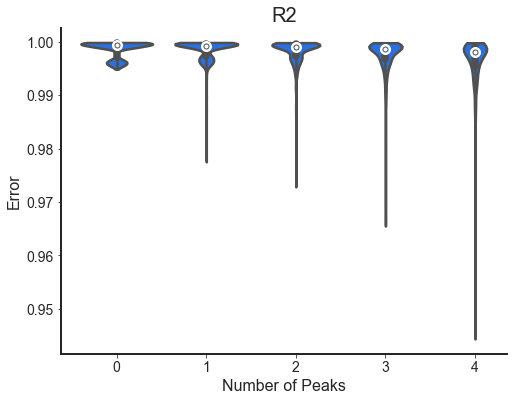

In [14]:
# Multi-peak fitting: plot R^2 levels across number of peaks
plot_errors_violin(r2_fits, 'R2', x_axis='n_oscs', plt_log=False)

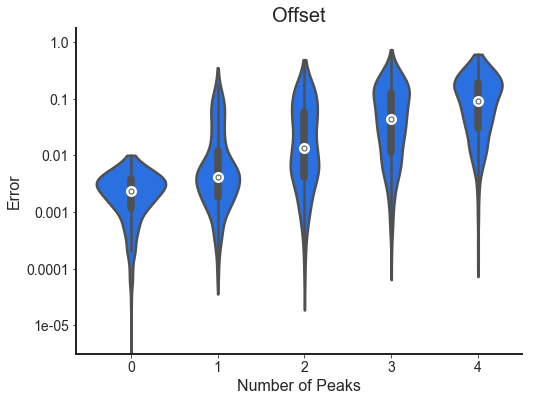

In [15]:
# Multi-peak fitting: plot error of aperiodic offset reconstruction across number of peaks
plot_errors_violin(ap_errors[:, :, 0], 'Offset',
                   x_axis='n_oscs', plt_log=True, ylim=[-5.5, 0.25])

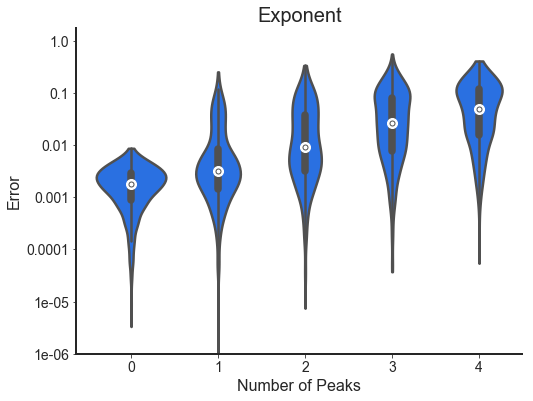

In [16]:
# Multi-peak fitting: plot error of aperiodic exponent reconstruction across number of peaks
plot_errors_violin(ap_errors[:, :, 1], 'Exponent',
                   x_axis='n_oscs', plt_log=True, ylim=[-6, 0.25])

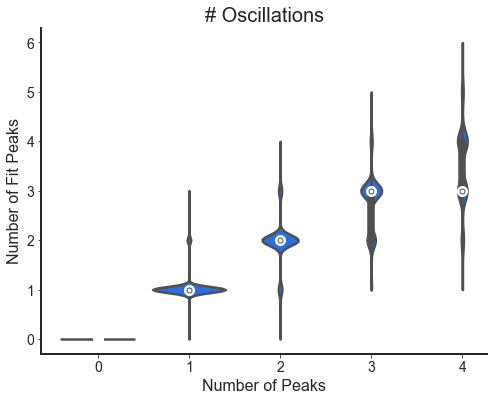

In [17]:
# Multi-peak fitting: plot number of fit peaks across number of simulated peaks
plot_errors_violin(n_fit_oscs, '# Oscillations',
                   x_axis='n_oscs', y_label='Number of Fit Peaks')

In [18]:
# Grab all data for number of peaks simulated
n_actual_oscillations = []
for n in n_oscs:
    n_actual_oscillations.append([n] * n_psds)
n_actual_oscillations = np.array(n_actual_oscillations)
n_actual_oscillations = n_actual_oscillations.flatten()

# Grab data for number of peaks fit
n_fit_oscs = n_fit_oscs.flatten()

# Collect together # simulated & # fit, for plotting
data = []
for aa, bb in zip(n_actual_oscillations, n_fit_oscs):
    data.append((aa, bb))
n_osc_counter = Counter(data)

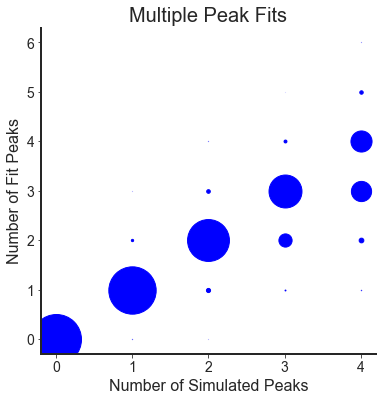

In [19]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_oscs_bubbles(n_osc_counter, save_fig=SAVE_FIG)

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 1.5], gaussian_params=[[19, 0.25, 1.0], [23, 0.25, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.0030, 1.4939                                          
                                                                                                  
          

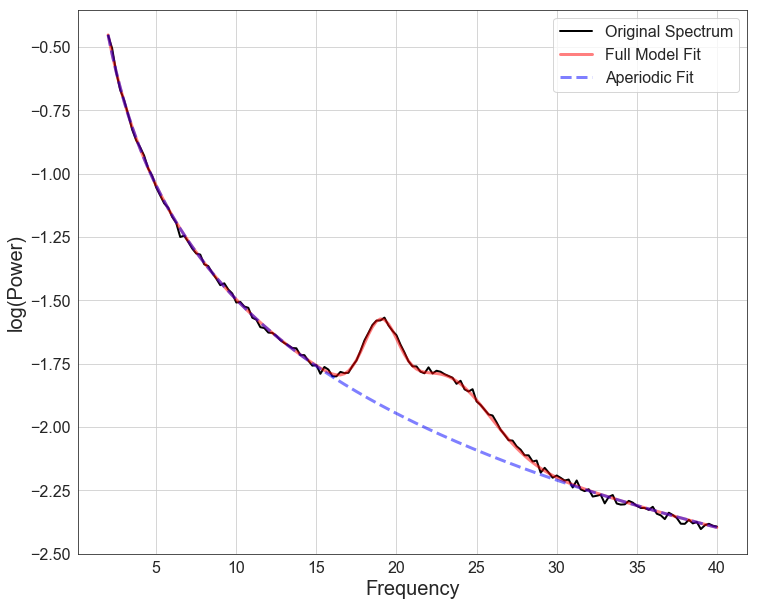

In [20]:
# Grab example case, plot & save out
ind = 1
fm = mp_fgs[2].get_fooof(ind, True)
print(mp_sim_params[2][ind])
fm.print_results()
fm.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='MultiPeak-2P')

SimParams(aperiodic_params=[0, 1.5], gaussian_params=[[10, 0.4, 2.0], [18, 0.15, 3.0], [21, 0.4, 1.0], [24, 0.2, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0434, 1.5152                                          
                                                                              

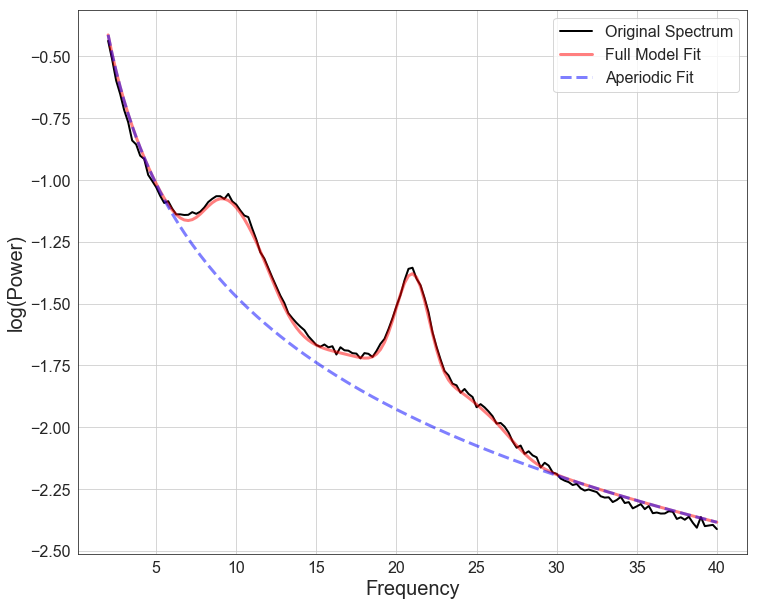

In [21]:
# Grab example case, plot & save out
ind = 10
fm = mp_fgs[-1].get_fooof(ind, True)
print(mp_sim_params[-1][ind])
fm.print_results()
fm.plot(save_fig=SAVE_FIG, file_path=FIGS_PATH, file_name='MultiPeak-4P')

### Check Fit Qualities

In [22]:
temp = r2_fits.flatten()

print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.9444 	0.9998
Median  R^2: 	0.9989
